In [15]:
import os
import pandas as pd
from openai import OpenAI
import google.generativeai as genai
from anthropic import Anthropic
import PyPDF2
import random
from tqdm import tqdm
import time
import re
import matplotlib.pyplot as plt
from io import BytesIO
from dotenv import load_dotenv

load_dotenv()

# Set up your API key
openai_client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
anthropic_client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))
genai.configure(api_key=os.environ.get("GOOGLE_API_KEY"))

# Define the injections and questions
literal_injections = [
    {
        "injection": "Максим народився в день весняного рівнодення.",
        "question": "Коли народився Максим?"
    },
    {
        "injection": "Улюбленим напоєм Захара Беркута був медовуха.",
        "question": "Який напій любив Захар Беркут?"
    },
    {
        "injection": "У бою під Опором Тугар Вовк втратив свого коня.",
        "question": "Кого втратив Тугар Вовк у бою під Опором?"
    },
    {
        "injection": "Бурунда-бегадир носив чорну шаблю з червоним руків'ям.",
        "question": "Яку шаблю мав Бурунда-бегадир?"
    },
    {
        "injection": "Село Тухля налічувало 137 хат.",
        "question": "Скільки хат було в селі Тухля?"
    }
]

associative_injections = [
    {
        "injection": "Захар Беркут віддав останній шматок хліба дитині з сусіднього села.",
        "question": "Як проявлялася доброта Захара Беркута?"
    },
    {
        "injection": "Мирослава ночами слухала спів вітру у горах, згадуючи батьківщину.",
        "question": "Що допомагало Мирославі згадувати рідний край?"
    },
    {
        "injection": "Максим йшов босоніж через сніг, лишаючи за собою криваві сліди.",
        "question": "Як Максим проявив витривалість?"
    },
    {
        "injection": "Старі тухольці називали тіснину священним порогом між двома світами.",
        "question": "Яке духовне значення мала тіснина для громади?"
    },
    {
        "injection": "Тугар Вовк ховав очі, коли люди говорили про честь.",
        "question": "Як ставився Тугар Вовк до теми честі?"
    }
]

def read_pdf(file_path):
    """Read and extract text from a PDF file with improved handling for Ukrainian text."""
    text = ""
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)

            # Get total pages for progress tracking
            total_pages = len(reader.pages)
            print(f"Total pages in PDF: {total_pages}")

            for page_num in tqdm(range(total_pages), desc="Reading PDF pages"):
                try:
                    page = reader.pages[page_num]
                    page_text = page.extract_text()

                    # Check for encoding issues with Ukrainian characters
                    if page_text:
                        # Try to fix common encoding issues with Ukrainian text
                        page_text = re.sub(r'Ð¢', 'Т', page_text)
                        page_text = re.sub(r'Ð', 'І', page_text)

                        # Add page separator for better context
                        text += f"\n--- Page {page_num + 1} ---\n{page_text}\n"
                    else:
                        print(f"Warning: Empty text extracted from page {page_num + 1}")
                except Exception as e:
                    print(f"Error extracting text from page {page_num + 1}: {str(e)}")
                    continue

            # Verify if we have a reasonable amount of text
            if len(text) < 1000:
                print("Warning: Very little text extracted from PDF. This might indicate encoding issues.")

                # Try an alternative extraction method
                print("Trying alternative extraction method...")
                alt_text = ""
                for page_num in range(total_pages):
                    page = reader.pages[page_num]
                    try:
                        # Extract raw text streams
                        content = page.get_contents()
                        if content:
                            for obj in content:
                                data = obj.get_data()
                                # Try to decode with different encodings
                                for encoding in ['utf-8', 'cp1251', 'iso-8859-1']:
                                    try:
                                        decoded = data.decode(encoding)
                                        alt_text += decoded + "\n"
                                        break
                                    except UnicodeDecodeError:
                                        continue
                    except:
                        pass

                # If alternative method found more text, use it
                if len(alt_text) > len(text):
                    print("Alternative method found more text. Using this instead.")
                    text = alt_text

    except Exception as e:
        print(f"Critical error reading PDF: {str(e)}")
        # Try to continue with what we have
        if not text:
            raise Exception(f"Failed to extract any text from {file_path}. Check if the file exists and is a valid PDF.")

    # Final verification
    text = text.strip()
    print(f"Successfully extracted {len(text)} characters from PDF")

    # Show a sample of the extracted text
    sample_length = min(500, len(text))
    print(f"\nSample of extracted text (first {sample_length} characters):")
    print(text[:sample_length] + "...\n")

    return text

def split_text_into_chunks(text, chunk_size=2000):
    """Split the text into chunks of approximately equal size."""
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

def inject_text(chunk, injection, position="beginning"):
    """Insert the injection at the specified position in the text chunk."""
    sentences = chunk.split('. ')

    if position == "beginning":
        # Insert after the first sentence
        if len(sentences) > 1:
            sentences.insert(1, injection)
        else:
            sentences.append(injection)
    elif position == "middle":
        # Insert in the middle
        middle_idx = len(sentences) // 2
        sentences.insert(middle_idx, injection)
    elif position == "end":
        # Insert before the last sentence
        if len(sentences) > 1:
            sentences.insert(len(sentences) - 1, injection)
        else:
            sentences.insert(0, injection)

    return '. '.join(sentences)

def query_model(model_name, prompt, max_tokens=500):
    """Query the specified model with the given prompt."""
    try:
        # Determine which API client to use based on the model name
        if model_name.startswith("gpt"):
            # OpenAI models
            response = openai_client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "Ти корисний помічник, який відповідає на запитання щодо української літератури."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                max_tokens=max_tokens
            )
            return response.choices[0].message.content.strip(), response.usage.prompt_tokens

        elif model_name.startswith("gemini"):
            # Google's Gemini models
            generation_config = {
                "temperature": 0,
                "max_output_tokens": max_tokens,
            }

            model = genai.GenerativeModel(
                model_name=model_name,
                generation_config=generation_config
            )

            system_prompt = "Ти корисний помічник, який відповідає на запитання щодо української літератури."
            response = model.generate_content(
                [system_prompt, prompt]
            )

            return response.text.strip(), response.usage_metadata.prompt_token_count

        elif model_name.startswith("claude"):
            # Anthropic's Claude models
            response = anthropic_client.messages.create(
                model=model_name,
                max_tokens=max_tokens,
                system="Ти корисний помічник, який відповідає на запитання щодо української літератури.",
                messages=[
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )
            # Добавлен небольшой интервал для API rate-limiting, но оставляем 3 секунды вместо 60
            time.sleep(30)
            return response.content[0].text.strip(), response.usage.input_tokens

        else:
            raise ValueError(f"Unsupported model: {model_name}")

    except Exception as e:
        print(f"Error querying {model_name} API: {e}")
        time.sleep(2)  # Wait a bit before retrying
        return f"API Error: {str(e)}"

def run_experiment(book_text, model_name="gpt-4o", positions=["beginning", "middle", "end"]):
    """Run the experiment with different injections and positions."""
    chunks = split_text_into_chunks(book_text)
    results = []

    # Select random chunks for each injection-position combination
    all_injections = literal_injections + associative_injections

    for injection_data in tqdm(all_injections, desc="Processing injections"):
        for position in positions:
            # Select a random chunk for this combination
            chunk = random.choice(chunks)

            # Inject the text
            injected_chunk = inject_text(book_text, injection_data["injection"], position)

            # Create prompt with the injected text and question
            prompt = f"{injected_chunk}\n\nПитання: {injection_data['question']}"

            # Query the model
            response, input_tokens = query_model(model_name, prompt)

            # Determine the injection type
            injection_type = "Literal" if injection_data in literal_injections else "Associative"

            # Store the results
            results.append({
                "Injection Type": injection_type,
                "Injection": injection_data["injection"],
                "Question": injection_data["question"],
                "Position": position,
                "Response": response,
                "Chunk Preview": chunk[:100] + "...",  # For debugging purposes
                "Input Tokens": input_tokens,
            })

            # Be nice to the API rate limits
            time.sleep(1)

    return pd.DataFrame(results)

def analyze_results(df):
    """Analyze the experiment results and add evaluation columns."""
    # Add columns for evaluation
    df['Correct Answer'] = False
    df['Answer Quality'] = ""
    df['Notes'] = ""

    # Define expected answers for literal injections
    literal_answers = {
        "Коли народився Максим?": "в день весняного рівнодення",
        "Який напій любив Захар Беркут?": "медовуха",
        "Кого втратив Тугар Вовк у бою під Опором?": "коня",
        "Яку шаблю мав Бурунда-бегадир?": "чорну шаблю з червоним руків'ям",
        "Скільки хат було в селі Тухля?": "137"
    }

    # Check literal answers
    for idx, row in df.iterrows():
        if row['Injection Type'] == 'Literal':
            question = row['Question']
            expected = literal_answers.get(question, "")

            # Check if the expected answer is in the response (case-insensitive)
            if expected.lower() in row['Response'].lower():
                df.at[idx, 'Correct Answer'] = True
                df.at[idx, 'Answer Quality'] = "Good - Direct match"
            else:
                df.at[idx, 'Answer Quality'] = "Poor - No match"

        else:  # Associative injections need manual review
            df.at[idx, 'Answer Quality'] = "Needs review - Associative question"

            # Add some automatic checks for associative responses
            injection = row['Injection'].lower()
            response = row['Response'].lower()

            # Check if key elements from the injection appear in the response
            key_elements = {
                "Як проявлялася доброта Захара Беркута?": ["хліб", "дитин", "сусідн"],
                "Що допомагало Мирославі згадувати рідний край?": ["спів", "вітр", "гор"],
                "Як Максим проявив витривалість?": ["босоніж", "сніг", "кривав"],
                "Яке духовне значення мала тіснина для громади?": ["священ", "поріг", "світ"],
                "Як ставився Тугар Вовк до теми честі?": ["хова", "очі"]
            }

            question = row['Question']
            elements = key_elements.get(question, [])

            matches = sum(1 for elem in elements if elem in response)
            if matches >= len(elements) // 2:
                df.at[idx, 'Correct Answer'] = True
                df.at[idx, 'Notes'] = f"Matched {matches}/{len(elements)} key elements"
            else:
                df.at[idx, 'Notes'] = f"Only matched {matches}/{len(elements)} key elements"

    return df

def create_visualizations(df):
    """Create visualization charts for the results."""
    # Set up the matplotlib style
    plt.style.use('ggplot')
    figures = {}

    # Figure 1: Overall accuracy by injection type
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    accuracy_by_type = df.groupby('Injection Type')['Correct Answer'].mean() * 100
    accuracy_by_type.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'])
    ax1.set_title('Accuracy by Injection Type', fontsize=16)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_xlabel('Injection Type', fontsize=12)
    ax1.set_ylim(0, 100)

    for i, v in enumerate(accuracy_by_type):
        ax1.text(i, v + 3, f"{v:.1f}%", ha='center', fontsize=12)

    figures['accuracy_by_type'] = fig1

    # Figure 2: Accuracy by position and injection type
    fig2, ax2 = plt.subplots(figsize=(12, 7))
    position_accuracy = df.groupby(['Position', 'Injection Type'])['Correct Answer'].mean() * 100
    position_accuracy.unstack().plot(kind='bar', ax=ax2)
    ax2.set_title('Accuracy by Position and Injection Type', fontsize=16)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_xlabel('Position', fontsize=12)
    ax2.set_ylim(0, 100)
    ax2.legend(title='Injection Type')

    figures['accuracy_by_position'] = fig2

    # Figure 3: Heatmap of accuracy by injection and position
    pivot_data = df.pivot_table(
        index='Injection',
        columns='Position',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    fig3, ax3 = plt.subplots(figsize=(12, 10))
    im = ax3.imshow(pivot_data, cmap='YlGnBu')
    ax3.set_title('Heatmap of Accuracy by Injection and Position', fontsize=16)
    ax3.set_xticks(range(len(pivot_data.columns)))
    ax3.set_yticks(range(len(pivot_data.index)))
    ax3.set_xticklabels(pivot_data.columns)
    ax3.set_yticklabels(pivot_data.index, fontsize=8)

    # Add colorbar
    cbar = fig3.colorbar(im)
    cbar.set_label('Accuracy (%)')

    # Add values to cells
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            value = pivot_data.iloc[i, j]
            color = 'white' if value > 50 else 'black'
            ax3.text(j, i, f"{value:.1f}%", ha="center", va="center", color=color, fontsize=8)

    figures['heatmap'] = fig3

    return figures

def save_visualizations_to_excel(excel_writer, figures):
    """Save the visualization figures to the Excel file."""
    for name, fig in figures.items():
        # Save figure to a bytes buffer
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        buf.seek(0)

        # Create a worksheet for the figure
        worksheet = excel_writer.book.add_worksheet(f'Chart - {name}')

        # Insert the image into the worksheet
        worksheet.insert_image('B2', '', {'image_data': buf})

        # Adjust column width and row height
        worksheet.set_column('B:B', 100)
        worksheet.set_row(1, 450)

def perform_text_analysis(df):
    """Perform text analysis on the responses."""
    # Define keywords for associative responses
    keywords = {
        "Як проявлялася доброта Захара Беркута?": [
            "щедрість", "допомога", "турбота", "милосердя", "хліб", "їжа", "дитина"
        ],
        "Що допомагало Мирославі згадувати рідний край?": [
            "вітер", "спів", "гори", "природа", "звуки", "ніч", "спогади"
        ],
        "Як Максим проявив витривалість?": [
            "біль", "сніг", "холод", "кров", "босоніж", "йти", "сліди", "терпіння"
        ],
        "Яке духовне значення мала тіснина для громади?": [
            "священна", "поріг", "світи", "духовний", "віра", "традиція", "перехід", "символ"
        ],
        "Як ставився Тугар Вовк до теми честі?": [
            "сором", "ховав", "очі", "уникав", "зрада", "нечесний", "безчесний"
        ]
    }

    # Text analysis results
    df['Keyword Matches'] = 0
    df['Mentioned Keywords'] = ""

    for idx, row in df.iterrows():
        if row['Injection Type'] == 'Associative':
            question = row['Question']
            response = row['Response'].lower()

            # Count keyword matches
            if question in keywords:
                matches = []
                for keyword in keywords[question]:
                    if keyword.lower() in response:
                        matches.append(keyword)

                df.at[idx, 'Keyword Matches'] = len(matches)
                df.at[idx, 'Mentioned Keywords'] = ", ".join(matches)

    return df

Reading the book...
Total pages in PDF: 10


Reading PDF pages: 100%|██████████| 10/10 [00:00<00:00, 55.76it/s]


Successfully extracted 25317 characters from PDF

Sample of extracted text (first 500 characters):
--- Page 1 ---
37
 36
ІСТОРИЧНЕ МИНУЛЕ УКРАЇНИЗАХАР БЕРКУТ
Образ громадського життя Карпатської Русі в XIII віці
Історична повість
(Скорочено)
Твір розпочинається з розповіді, яку веде бабуся для своїх онуків. Події 
відбуваються в старовинному руському1 селі Тухлі, яке розташоване в долині 
Карпатських гір. Тухольці об’єдналися в трудову громаду, на чолі якої стояв Захар 
Беркут — найстаріший і наймудріший чоловік. Мешканці села мали рівні права, 
почувалися в цьому краю вільними й незалежними....


Running experiment with 5 different models for comparison

=== Running experiment with model: claude-3-7-sonnet-latest ===


Processing injections: 100%|██████████| 10/10 [18:10<00:00, 109.00s/it]



=== Running experiment with model: claude-3-5-sonnet-latest ===


Processing injections: 100%|██████████| 10/10 [19:29<00:00, 116.93s/it]



=== Running experiment with model: gpt-4o ===


Processing injections: 100%|██████████| 10/10 [09:01<00:00, 54.20s/it]



=== Running experiment with model: gemini-1.5-pro ===


Processing injections: 100%|██████████| 10/10 [02:05<00:00, 12.57s/it]



=== Running experiment with model: gemini-2.0-flash ===


Processing injections: 100%|██████████| 10/10 [00:58<00:00,  5.82s/it]



Model Comparison:
                   Model  Associative  Literal  Avg Tokens (Associative)  Avg Tokens (Literal)  Total Tokens  Overall
claude-3-5-sonnet-latest       73.33%   93.33%                 12055.40%             12047.20%        361539   83.33%
claude-3-7-sonnet-latest       80.00%   93.33%                 12055.40%             12047.20%        361539   86.67%
          gemini-1.5-pro       73.33%   93.33%                  9695.80%              9690.80%        290799   83.33%
        gemini-2.0-flash       73.33%  100.00%                  9695.80%              9690.80%        290799   86.67%
                  gpt-4o       53.33%  100.00%                  9787.00%              9779.80%        293502   76.67%

Token Usage Summary:
                   Model  Avg Tokens (Literal)  Avg Tokens (Associative)  Total Tokens
claude-3-5-sonnet-latest               12047.2                   12055.4        361539
claude-3-7-sonnet-latest               12047.2                   12055.4     

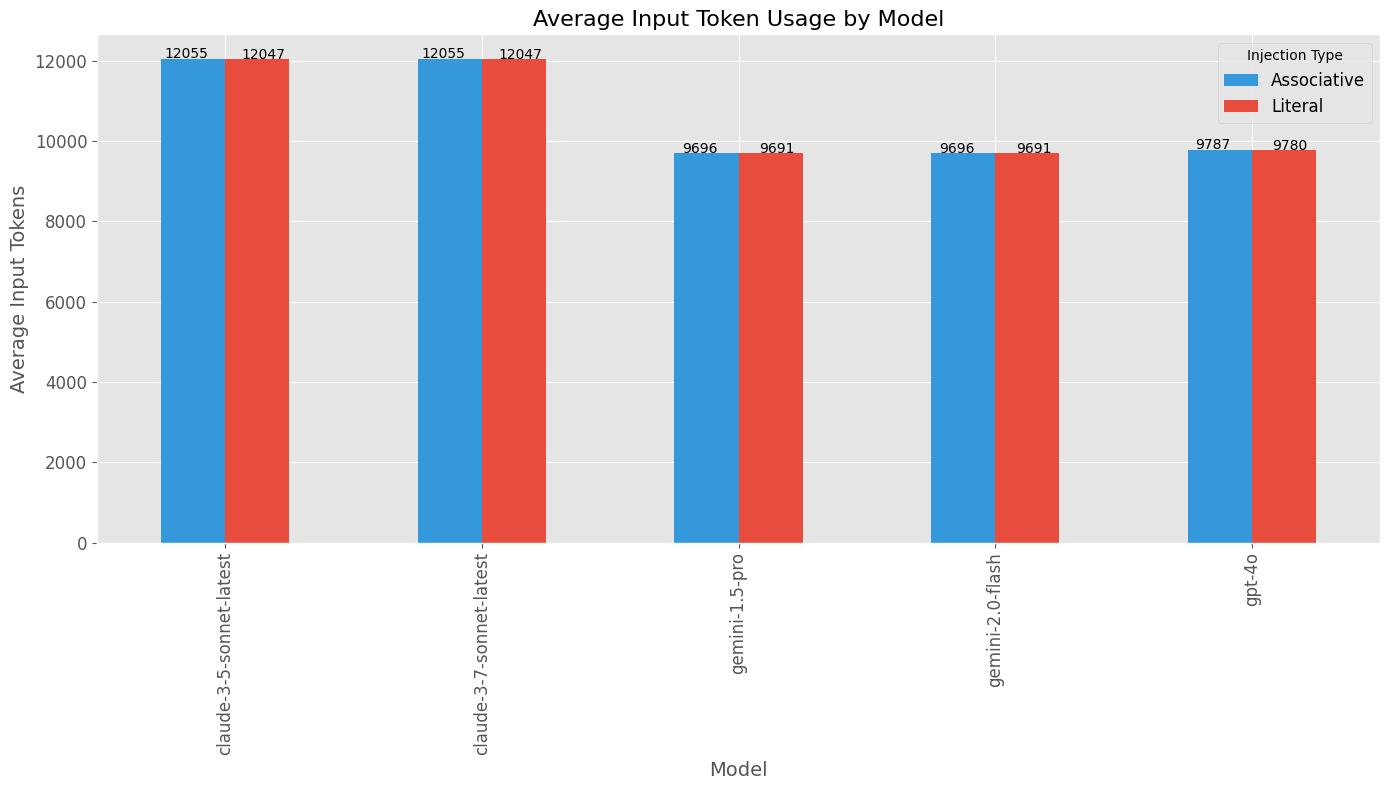

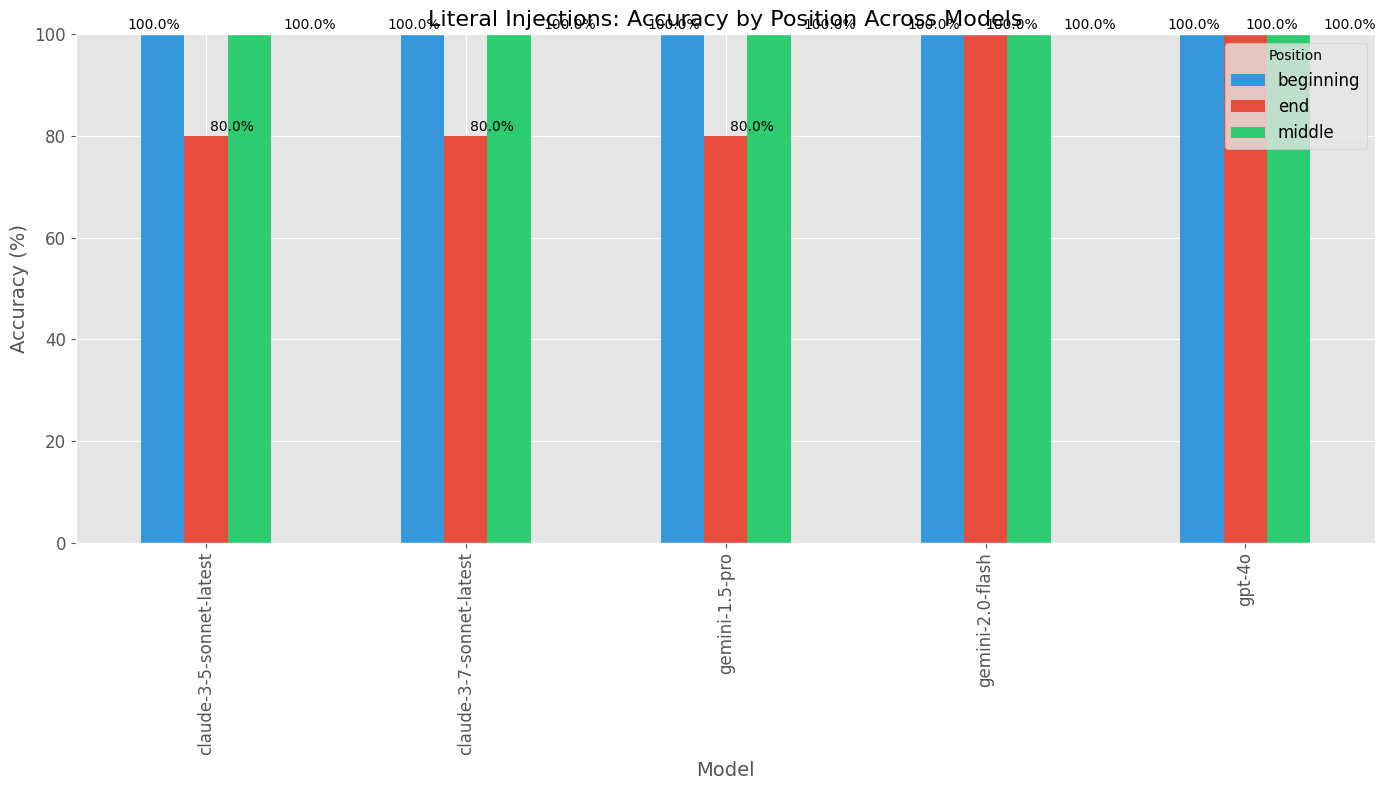

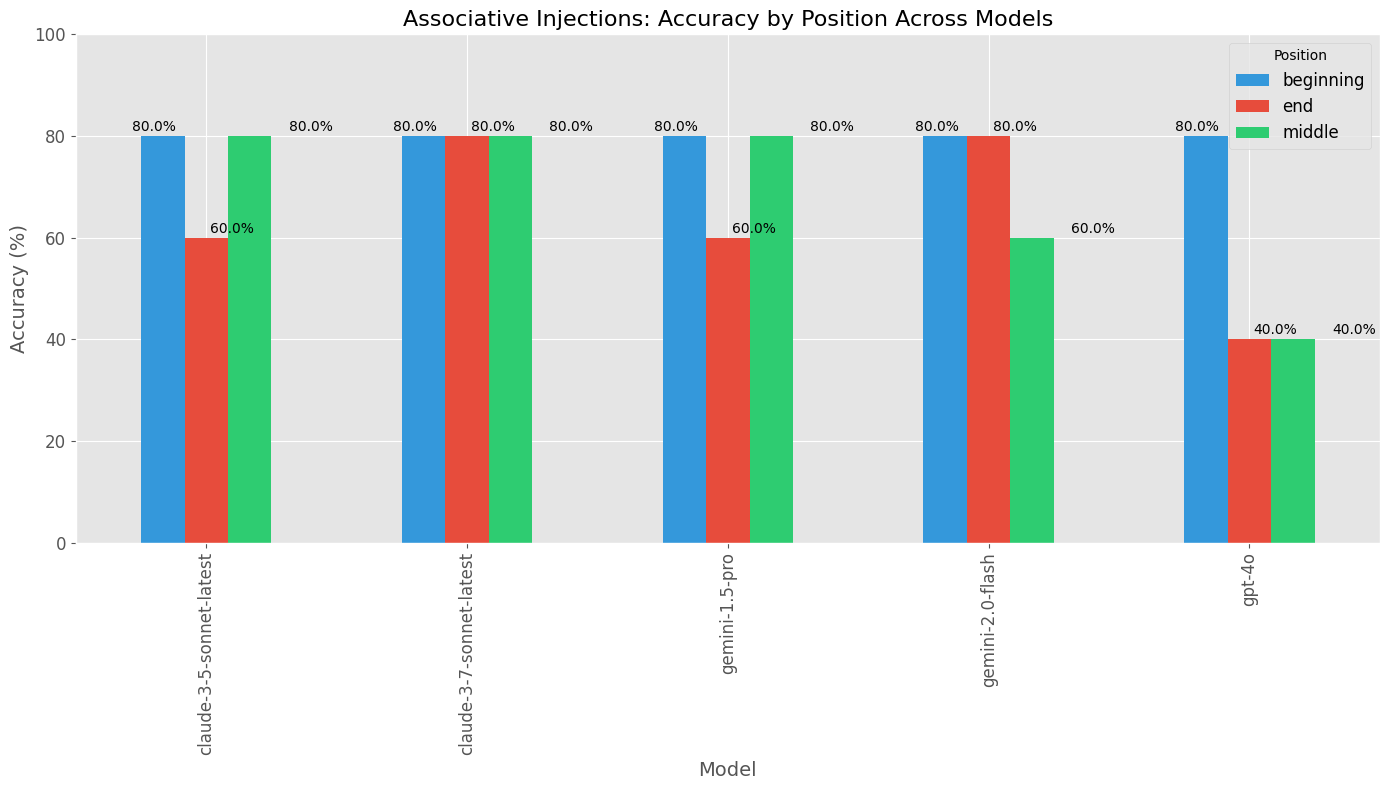

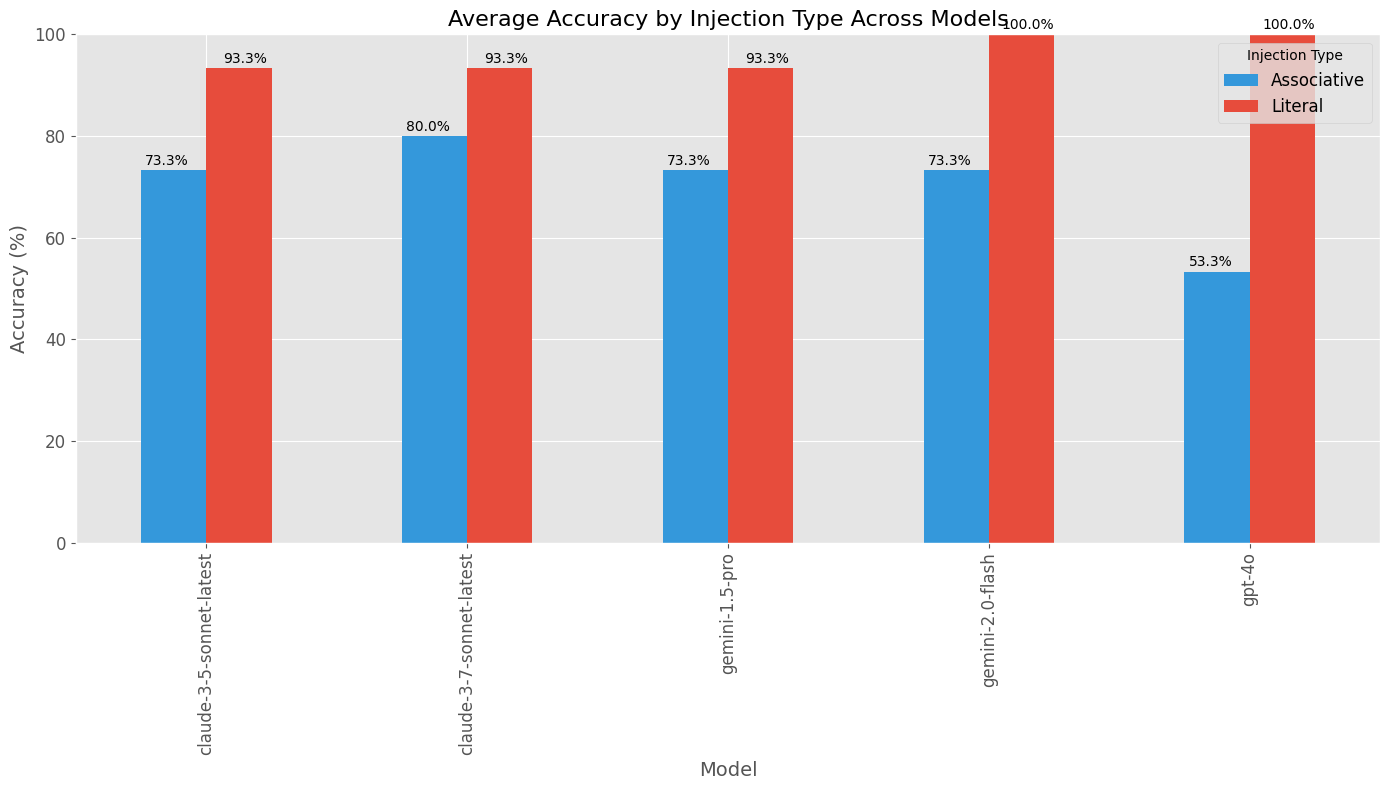

In [16]:
def create_model_comparison_visualizations(combined_results):
    """Create visualization charts comparing model performance."""
    plt.style.use('ggplot')
    figures = {}

    # Set color palette for models
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

    # Create tokens visualization
    fig_tokens, ax_tokens = plt.subplots(figsize=(14, 8))

    # Calculate average tokens by model and injection type
    token_usage = combined_results.groupby(['Model', 'Injection Type'])['Input Tokens'].mean().unstack()

    # Plot grouped bar chart for token usage
    token_usage.plot(kind='bar', ax=ax_tokens, color=['#3498db', '#e74c3c'])

    ax_tokens.set_title('Average Input Token Usage by Model', fontsize=16)
    ax_tokens.set_ylabel('Average Input Tokens', fontsize=14)
    ax_tokens.set_xlabel('Model', fontsize=14)
    ax_tokens.legend(title='Injection Type', fontsize=12)
    ax_tokens.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(token_usage.index):
        for j, inj_type in enumerate(token_usage.columns):
            value = token_usage.loc[model, inj_type]
            ax_tokens.text(i - 0.15 + (j * 0.3), value + 5, f"{value:.0f}", ha='center', fontsize=10)

    plt.tight_layout()
    figures['token_usage'] = fig_tokens

    # Figure 1: Literal injections accuracy by position for each model
    fig1, ax1 = plt.subplots(figsize=(14, 8))

    # Filter for literal injections only
    literal_results = combined_results[combined_results['Injection Type'] == 'Literal']

    # Create pivot table: Model x Position -> Accuracy
    literal_pivot = literal_results.pivot_table(
        index='Model',
        columns='Position',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    # Plot grouped bar chart
    literal_pivot.plot(kind='bar', ax=ax1, color=colors[:len(literal_pivot.columns)])

    ax1.set_title('Literal Injections: Accuracy by Position Across Models', fontsize=16)
    ax1.set_ylabel('Accuracy (%)', fontsize=14)
    ax1.set_xlabel('Model', fontsize=14)
    ax1.set_ylim(0, 100)
    ax1.legend(title='Position', fontsize=12)
    ax1.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(literal_pivot.index):
        for j, position in enumerate(literal_pivot.columns):
            value = literal_pivot.loc[model, position]
            ax1.text(i - 0.2 + (j * 0.3), value + 1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()
    figures['literal_by_position'] = fig1

    # Figure 2: Associative injections accuracy by position for each model
    fig2, ax2 = plt.subplots(figsize=(14, 8))

    # Filter for associative injections only
    associative_results = combined_results[combined_results['Injection Type'] == 'Associative']

    # Create pivot table: Model x Position -> Accuracy
    associative_pivot = associative_results.pivot_table(
        index='Model',
        columns='Position',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    # Plot grouped bar chart
    associative_pivot.plot(kind='bar', ax=ax2, color=colors[:len(associative_pivot.columns)])

    ax2.set_title('Associative Injections: Accuracy by Position Across Models', fontsize=16)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.set_xlabel('Model', fontsize=14)
    ax2.set_ylim(0, 100)
    ax2.legend(title='Position', fontsize=12)
    ax2.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(associative_pivot.index):
        for j, position in enumerate(associative_pivot.columns):
            value = associative_pivot.loc[model, position]
            ax2.text(i - 0.2 + (j * 0.3), value + 1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()
    figures['associative_by_position'] = fig2

    # Figure 3: Average accuracy by injection type for each model
    fig3, ax3 = plt.subplots(figsize=(14, 8))

    # Create pivot table: Model x Injection Type -> Accuracy
    avg_pivot = combined_results.pivot_table(
        index='Model',
        columns='Injection Type',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    # Plot grouped bar chart
    avg_pivot.plot(kind='bar', ax=ax3, color=['#3498db', '#e74c3c'])

    ax3.set_title('Average Accuracy by Injection Type Across Models', fontsize=16)
    ax3.set_ylabel('Accuracy (%)', fontsize=14)
    ax3.set_xlabel('Model', fontsize=14)
    ax3.set_ylim(0, 100)
    ax3.legend(title='Injection Type', fontsize=12)
    ax3.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(avg_pivot.index):
        for j, inj_type in enumerate(avg_pivot.columns):
            value = avg_pivot.loc[model, inj_type]
            ax3.text(i - 0.15 + (j * 0.3), value + 1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()
    figures['avg_by_type'] = fig3

    return figures

def compare_models(book_text, models):
    """Run the experiment with multiple models and compare their performance."""
    all_results = []

    for model in models:
        print(f"\n=== Running experiment with model: {model} ===")
        results_df = run_experiment(book_text, model_name=model)
        results_df['Model'] = model

        # Analyze the results for this model
        results_df = analyze_results(results_df)
        results_df = perform_text_analysis(results_df)

        all_results.append(results_df)

    # Combine all results
    combined_results = pd.concat(all_results)

    # Create model comparison visualizations
    comparison_figures = create_model_comparison_visualizations(combined_results)

    # Create traditional model comparison table
    model_comparison = combined_results.groupby(['Model', 'Injection Type'])['Correct Answer'].mean().unstack().reset_index()
    model_comparison.columns = ['Model', 'Associative', 'Literal']

    # Add average input tokens information
    avg_tokens = combined_results.groupby(['Model', 'Injection Type'])['Input Tokens'].mean().unstack().reset_index()
    model_comparison['Avg Tokens (Associative)'] = avg_tokens['Associative']
    model_comparison['Avg Tokens (Literal)'] = avg_tokens['Literal']

    # Add total input tokens
    total_tokens = combined_results.groupby(['Model'])['Input Tokens'].sum().reset_index()
    model_comparison = pd.merge(model_comparison, total_tokens, on='Model')
    model_comparison.rename(columns={'Input Tokens': 'Total Tokens'}, inplace=True)

    # Add position-specific data
    position_comparison = combined_results.groupby(['Model', 'Position', 'Injection Type'])['Correct Answer'].mean().unstack().reset_index()

    # Add token information to position comparison
    token_by_position = combined_results.groupby(['Model', 'Position', 'Injection Type'])['Input Tokens'].mean().unstack().reset_index()
    token_by_position.columns = ['Model', 'Position', 'Tokens (Associative)', 'Tokens (Literal)'] if 'Associative' in token_by_position.columns else ['Model', 'Position', 'Tokens (Literal)', 'Tokens (Associative)']
    position_comparison = pd.merge(position_comparison, token_by_position, on=['Model', 'Position'])

    # Calculate overall accuracy
    model_comparison['Overall'] = combined_results.groupby('Model')['Correct Answer'].mean().values

    # Format as percentages
    for col in ['Associative', 'Literal', 'Overall']:
        model_comparison[col] = model_comparison[col] * 100

    return combined_results, model_comparison, position_comparison, comparison_figures

def save_comparison_visualizations_to_excel(excel_writer, figures):
    """Save the visualization figures to the Excel file."""
    for name, fig in figures.items():
        # Save figure to a bytes buffer
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)

        # Create a worksheet for the figure
        worksheet = excel_writer.book.add_worksheet(f'Chart - {name}')

        # Insert the image into the worksheet
        worksheet.insert_image('B2', '', {'image_data': buf})

        # Adjust column width and row height
        worksheet.set_column('B:B', 120)
        worksheet.set_row(1, 500)

def main():
    # Path to the book
    book_path = "books/zahar-berkut.pdf"

    # Define models to test
    models_to_test = [
        "claude-3-7-sonnet-latest",
        "claude-3-5-sonnet-latest",
        "gpt-4o",
        "gemini-1.5-pro",
        "gemini-2.0-flash",
    ]

    # Check if the file exists
    if not os.path.exists(book_path):
        print(f"Error: File {book_path} not found!")
        return

    # Read the book
    print("Reading the book...")
    book_text = read_pdf(book_path)

    print(f"\nRunning experiment with {len(models_to_test)} different models for comparison")
    combined_results, model_comparison, position_comparison, comparison_figures = compare_models(book_text, models_to_test)

    # Print model comparison
    print("\nModel Comparison:")
    print(model_comparison.to_string(index=False, float_format=lambda x: f"{x:.2f}%"))

    # Print token usage summary
    print("\nToken Usage Summary:")
    token_summary = model_comparison[['Model', 'Avg Tokens (Literal)', 'Avg Tokens (Associative)', 'Total Tokens']]
    print(token_summary.to_string(index=False))

    # Save results
    output_path = "language_model_focus_experiment_results_multi_model.xlsx"
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        # Save raw data
        combined_results.to_excel(writer, sheet_name='All Results', index=False)
        model_comparison.to_excel(writer, sheet_name='Model Comparison', index=False)

        # Create a dedicated token analysis sheet
        token_analysis = combined_results.groupby(['Model', 'Injection Type', 'Position'])['Input Tokens'].agg(['mean', 'sum', 'count']).reset_index()
        token_analysis.rename(columns={'mean': 'Avg Tokens', 'sum': 'Total Tokens', 'count': 'Sample Count'}, inplace=True)
        token_analysis.to_excel(writer, sheet_name='Token Analysis', index=False)

        # Save position comparison
        for position in ['beginning', 'middle', 'end']:
            pos_data = position_comparison[position_comparison['Position'] == position]
            pos_data.to_excel(writer, sheet_name=f'Position - {position}', index=False)

        # Save visualizations
        save_comparison_visualizations_to_excel(writer, comparison_figures)

    print(f"Multi-model results saved to {output_path}")

if __name__ == "__main__":
    main()